In [0]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [0]:
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)
batch_size = 256
num_epochs = 50

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train / 127.5 - 1., X_test / 127.5 -1

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
X_train = X_train.reshape(-1, *input_shape).astype(np.float32)
X_test = X_test.reshape(-1, *input_shape).astype(np.float32)

In [0]:
BUFFER_SIZE = 200_000
BATCH_SIZE = 256

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
val_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
train_steps_per_epoch = tf.math.ceil(X_train.shape[0] / BATCH_SIZE)
val_steps_per_epoch = tf.math.ceil(X_test.shape[0] / BATCH_SIZE)

In [0]:
kernel_size = 4
noise_dim = 2
filters_orig_gen = 64
layer_depth_gen = 3
filters_orig_disc = 64
layer_depth_disc = 3

In [0]:
from tensorflow.keras import layers

In [0]:
def generator_model():
  model = tf.keras.Sequential([
          tf.keras.layers.Dense(7 * 7 * 256, input_shape=(100, )),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.LeakyReLU(),

          tf.keras.layers.Reshape(target_shape=(7, 7, 256)),

          tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='same'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.LeakyReLU(),
          
          tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.LeakyReLU(),

          tf.keras.layers.Conv2DTranspose(1, (3, 3), strides = (2,2), padding='same', activation='tanh'),
  ])
  return model

In [0]:
def discriminator_model():
  model = tf.keras.Sequential([
          tf.keras.layers.Conv2D(64, kernel_size=(5,5), input_shape=(28,28,1), strides=2, padding='same'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.LeakyReLU(),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=2, padding='same'),
          tf.keras.layers.LeakyReLU(),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.Conv2D(256, kernel_size=(3,3), strides=2, padding='same'),
          tf.keras.layers.LeakyReLU(),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(1),
  ])
  return model

In [0]:
generator = generator_model()
discriminator = discriminator_model()

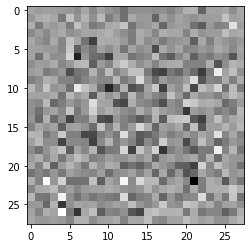

In [155]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [156]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00010242]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [0]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
BATCH_SIZE = 128
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [164]:
EPOCHS = 100
import time

for epoch in range(EPOCHS):
  start = time.time()

  for image_batch in train_dataset:
    gen_loss, disc_loss = train_step(image_batch)
  
  print(f'Epoch {epoch + 1} completed: Time: {time.time() - start}, loss {gen_loss}--{disc_loss}')

Epoch 1 completed: Time: 18.800602197647095, loss 5.143141746520996--0.040514856576919556
Epoch 2 completed: Time: 15.177192687988281, loss 4.523449420928955--0.24916468560695648
Epoch 3 completed: Time: 15.115487337112427, loss 2.5860469341278076--0.4664159119129181
Epoch 4 completed: Time: 15.110501527786255, loss 2.6451144218444824--0.43617966771125793
Epoch 5 completed: Time: 15.179088830947876, loss 2.0861124992370605--0.6320942044258118
Epoch 6 completed: Time: 15.171453952789307, loss 3.200198173522949--0.4547361135482788
Epoch 7 completed: Time: 15.15543246269226, loss 3.011258125305176--0.5221967697143555
Epoch 8 completed: Time: 15.18050217628479, loss 2.9380953311920166--0.4600459337234497
Epoch 9 completed: Time: 15.19673752784729, loss 3.178009510040283--0.5956310033798218
Epoch 10 completed: Time: 15.189095735549927, loss 2.440446376800537--0.5567805767059326
Epoch 11 completed: Time: 15.192461729049683, loss 1.4103453159332275--0.8670836091041565
Epoch 12 completed: Time

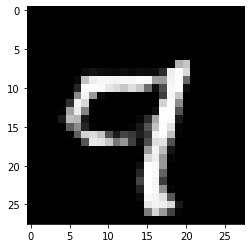

In [171]:
plt.imshow(generator(tf.random.normal([1, 100]), training=False)[0, :, :, 0], cmap='gray')